#Cat and Dog Image Classification
## 1st approch: Using custom model using tensorflow
## 2nd approch: Using transfer learning model like VGG16
## Comparing both the model against each other in various metrics like precision, f1 and recall

###Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score

from tensorflow.keras import layers,models,optimizers,regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Basic parameters and value initilization

In [3]:
FIRST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

##Basic data preprocessing and exploratory data analysis(EDA)

In [4]:
basepath = "/content/drive/MyDrive/Codes/Datasets/cats_and_dogs/train"

In [5]:
foldernames = os.listdir(basepath)
filenames = []
categories = []

for folders in foldernames:
  filepath = os.path.join(basepath,folders)
  files = os.listdir(filepath)
  for file in files:
    filenames.append(os.path.join(filepath,file))
    if folders == 'dogs':
      categories.append(1)
    else:
      categories.append(0)


# print(filenames)
df = pd.DataFrame({
    'filename' : filenames,
    'category' : categories
})

In [6]:
df.head()

,filename,category
0,/content/drive/MyDrive/Codes/Datasets/cats_and...,0
1,/content/drive/MyDrive/Codes/Datasets/cats_and...,0
2,/content/drive/MyDrive/Codes/Datasets/cats_and...,0
3,/content/drive/MyDrive/Codes/Datasets/cats_and...,0
4,/content/drive/MyDrive/Codes/Datasets/cats_and...,0


In [7]:
df.tail()

,filename,category
1595,/content/drive/MyDrive/Codes/Datasets/cats_and...,1
1596,/content/drive/MyDrive/Codes/Datasets/cats_and...,1
1597,/content/drive/MyDrive/Codes/Datasets/cats_and...,1
1598,/content/drive/MyDrive/Codes/Datasets/cats_and...,1
1599,/content/drive/MyDrive/Codes/Datasets/cats_and...,1


<Axes: >

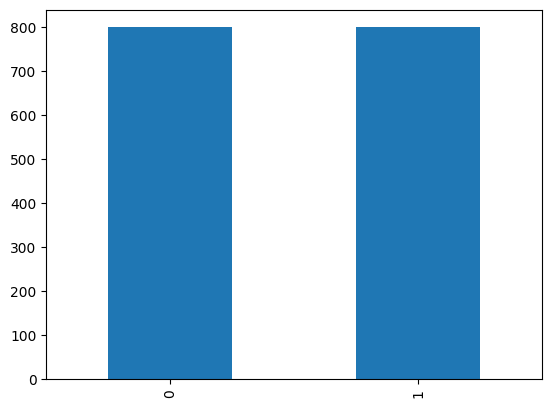

In [8]:
df['category'].value_counts().plot.bar()

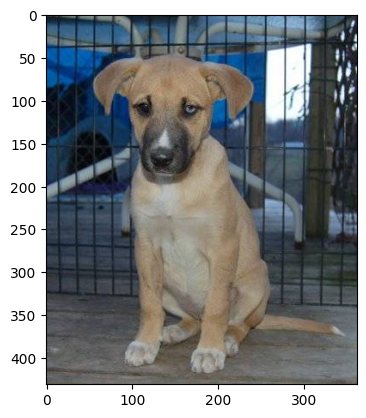

In [9]:
sample = df['filename'][random.randint(0, 1600)]
image = load_img(sample)
plt.imshow(image)

##Preparing custom model with 4 set of:
1. Convolutional layers
2. Batch normalization layer
4. Max pooling layer
4. Dropout layer

##In the end:
1. Flatten layer
2. 2 Dense layer
3. 1 Batch normalization layer
4. Final Dense layer for output.

In [10]:
def build_model():

  model = models.Sequential()

  model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(128,activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(2, activation = 'softmax'))

  return model


In [11]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer = 'ADAM', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

###Setting Callbacks

In [12]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [13]:
callbacks = [earlystop, learning_rate_reduction]

##Preparing Data for training

In [14]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [15]:

train_df, validation_df = train_test_split(df, train_size = 0.8, random_state = 42)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

<Axes: >

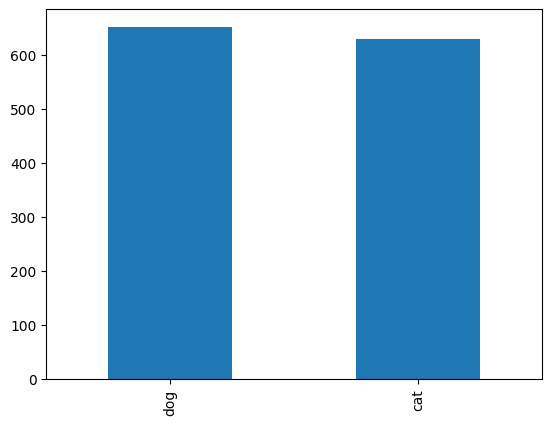

In [16]:
train_df['category'].value_counts().plot.bar()

<Axes: >

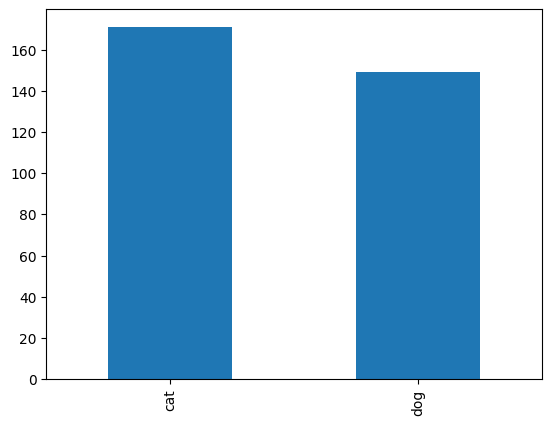

In [17]:
validation_df['category'].value_counts().plot.bar()

In [18]:
total_train = train_df.shape[0]
total_validation = validation_df.shape[0]
BATCH_SIZE = 16

In [19]:
train_data = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1.0 /255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip= True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_data = ImageDataGenerator(
    rescale = 1.0 /255,
)

In [20]:
train_img_data = train_data.flow_from_dataframe(
    train_df,
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE
)

validation_img_data = validation_data.flow_from_dataframe(
    validation_df,
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE
)

Found 1280 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.


##Training the custom model

In [21]:
train_history = model.fit(train_img_data,
                          epochs = 25,
                          validation_data = validation_img_data,
                          validation_steps = total_validation // BATCH_SIZE,
                          steps_per_epoch = total_train/BATCH_SIZE,
                          callbacks = callbacks)

Epoch 1/25
80/80 [==============================] - 642s 8s/step - loss: 0.8823 - accuracy: 0.5422 - val_loss: 2.3661 - val_accuracy: 0.5344 - lr: 0.0010
Epoch 2/25
80/80 [==============================] - 11s 140ms/step - loss: 0.7572 - accuracy: 0.5984 - val_loss: 2.1319 - val_accuracy: 0.5344 - lr: 0.0010
Epoch 3/25
80/80 [==============================] - ETA: 0s - loss: 0.7716 - accuracy: 0.5797
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
80/80 [==============================] - 12s 151ms/step - loss: 0.7716 - accuracy: 0.5797 - val_loss: 1.2177 - val_accuracy: 0.5344 - lr: 0.0010
Epoch 4/25
80/80 [==============================] - 11s 140ms/step - loss: 0.7256 - accuracy: 0.5742 - val_loss: 0.8135 - val_accuracy: 0.5375 - lr: 5.0000e-04
Epoch 5/25
80/80 [==============================] - 12s 151ms/step - loss: 0.7130 - accuracy: 0.6055 - val_loss: 0.8983 - val_accuracy: 0.5281 - lr: 5.0000e-04
Epoch 6/25
80/80 [==============================] - 11s

In [22]:
model.save_weights("model.h5")

##Checking model performance

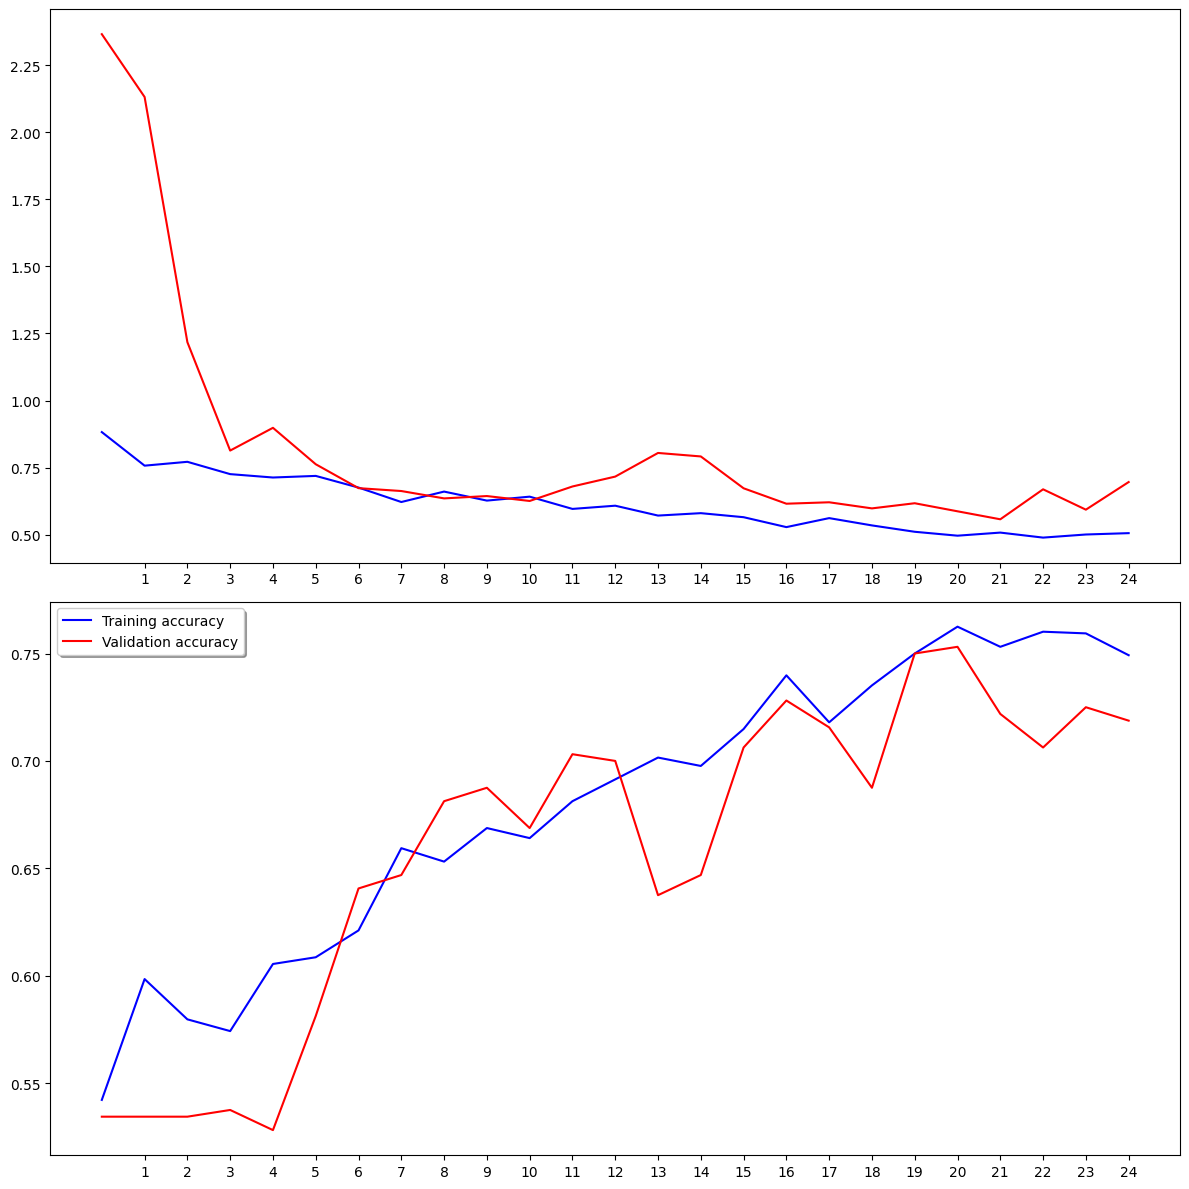

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12, 12))
ax1.plot(train_history.history['loss'], color = 'b', label="Training loss")
ax1.plot(train_history.history['val_loss'], color = 'r', label="Validation loss")
ax1.set_xticks(np.arange(1,25, 1))

ax2.plot(train_history.history['accuracy'], color = 'b', label= "Training accuracy")
ax2.plot(train_history.history['val_accuracy'], color = 'r', label = "Validation accuracy")
ax2.set_xticks(np.arange( 1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

##Preparing Data for prediction

In [24]:
train_basepath = "/content/drive/MyDrive/Codes/Datasets/cats_and_dogs/validation"

foldernames = os.listdir(train_basepath)
filenames = []
categories = []

for folders in foldernames:
  filepath = os.path.join(basepath,folders)
  files = os.listdir(filepath)
  for file in files:
    filenames.append(os.path.join(filepath,file))
    if folders == 'dogs':
      categories.append(1)
    else:
      categories.append(0)


validate_df = pd.DataFrame({
    'filename' : filenames,
    'category' : categories
})

In [25]:
test_gen = ImageDataGenerator(rescale = 1.0 / 255)

test_generator = test_gen.flow_from_dataframe(
    validate_df,
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1600 validated image filenames.


In [26]:
predict = model.predict(test_generator)

100/100 [==============================] - 5s 48ms/step


In [27]:
validate_df['category_predict'] = predict.argmax(axis=-1)

##Prediction result

<Axes: >

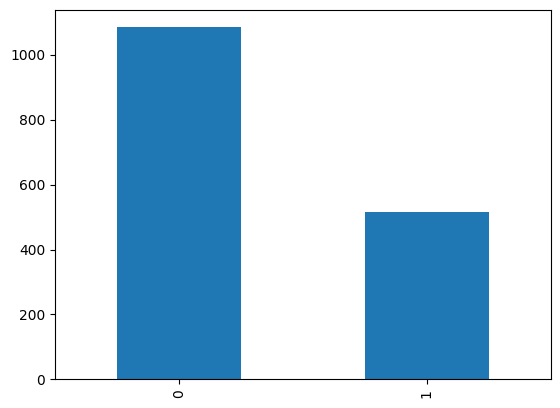

In [28]:
validate_df['category_predict'].value_counts().plot.bar()

In [29]:
performance_metrics = {}

performance_metrics['precision'] = precision_score(validate_df['category'], validate_df['category_predict'])
performance_metrics['f1'] = f1_score(validate_df['category'], validate_df['category_predict'])
performance_metrics['recall'] = recall_score(validate_df['category'], validate_df['category_predict'])

In [30]:
print(performance_metrics['precision'], performance_metrics['f1'], performance_metrics['recall'])

0.875968992248062 0.6869300911854103 0.565


##Training with Vgg16

In [31]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [32]:
train_imagedata_vgg16 = ImageDataGenerator(rescale = 1/255.0, preprocessing_function=preprocess_input)
test_imagedata_vgg16 = ImageDataGenerator(rescale = 1/255.0, preprocessing_function=preprocess_input)

In [33]:
train_image_data = train_imagedata_vgg16.flow_from_dataframe(
    train_df,
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE
)

validation_image_data = test_imagedata_vgg16.flow_from_dataframe(
    validation_df,
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE
)

Found 1280 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.


##Model preparation

In [34]:
vgg16_base_model = VGG16(input_shape = train_image_data.image_shape, weights = 'imagenet', include_top = False)

for layer in vgg16_base_model.layers:
  layer.trainable = False

x = vgg16_base_model.output
x = layers.Flatten()(x)
predict = layers.Dense(2, activation = 'softmax')(x)
vgg16_model = models.Model(inputs=vgg16_base_model.input, outputs = predict)

58889256/58889256 [==============================] - 4s 0us/step


In [35]:
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Accuracy'])
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [36]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_Accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

CALLBACKS = [earlystop, learning_rate_reduction]

##Training the VGG 16 model

In [37]:
vgg16_hist = vgg16_model.fit(train_image_data, validation_data = validation_image_data, epochs = 10, callbacks = CALLBACKS)

Epoch 1/10
80/80 [==============================] - 8s 76ms/step - loss: 0.3731 - Accuracy: 0.8211 - val_loss: 0.3391 - val_Accuracy: 0.8562 - lr: 0.0010
Epoch 2/10
80/80 [==============================] - 6s 69ms/step - loss: 0.2019 - Accuracy: 0.9187 - val_loss: 0.3365 - val_Accuracy: 0.8562 - lr: 0.0010
Epoch 3/10
80/80 [==============================] - ETA: 0s - loss: 0.1481 - Accuracy: 0.9523
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
80/80 [==============================] - 5s 68ms/step - loss: 0.1481 - Accuracy: 0.9523 - val_loss: 0.3193 - val_Accuracy: 0.8594 - lr: 0.0010
Epoch 4/10
80/80 [==============================] - 7s 83ms/step - loss: 0.0920 - Accuracy: 0.9797 - val_loss: 0.3161 - val_Accuracy: 0.8719 - lr: 5.0000e-04
Epoch 5/10
80/80 [==============================] - ETA: 0s - loss: 0.0794 - Accuracy: 0.9820
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
80/80 [==============================] - 5s 67ms/st

##Training performance analysis

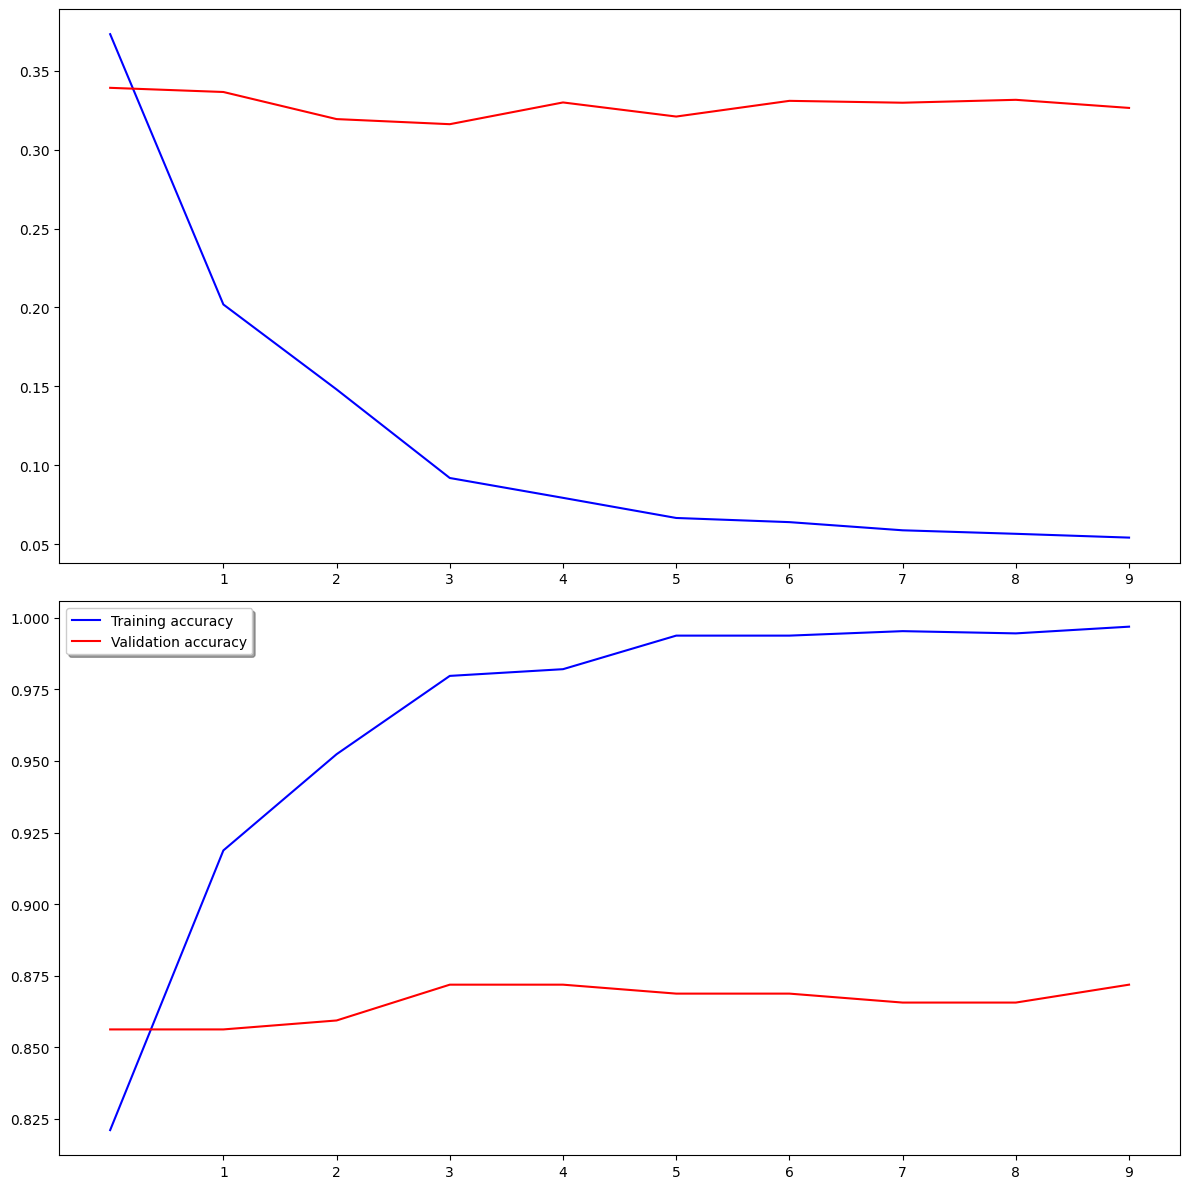

In [38]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12, 12))
ax1.plot(vgg16_hist.history['loss'], color = 'b', label="Training loss")
ax1.plot(vgg16_hist.history['val_loss'], color = 'r', label="Validation loss")
ax1.set_xticks(np.arange(1,10, 1))

ax2.plot(vgg16_hist.history['Accuracy'], color = 'b', label= "Training accuracy")
ax2.plot(vgg16_hist.history['val_Accuracy'], color = 'r', label = "Validation accuracy")
ax2.set_xticks(np.arange( 1, 10, 1))

legend = plt.legend(shadow=True)
plt.tight_layout()
plt.show()

In [39]:
vgg16_predict = vgg16_model.predict(test_generator)

100/100 [==============================] - 5s 48ms/step


In [40]:
validate_df['category_predict_vgg16'] = vgg16_predict.argmax(axis=-1)

##Model performance analysis

In [41]:
performance_metrics_vgg16 = {}
performance_metrics_vgg16['precision'] = precision_score(validate_df['category'], validate_df['category_predict_vgg16'])
performance_metrics_vgg16['f1'] = f1_score(validate_df['category'], validate_df['category_predict_vgg16'])
performance_metrics_vgg16['recall'] = recall_score(validate_df['category'], validate_df['category_predict_vgg16'])

##2 Models performance comparison

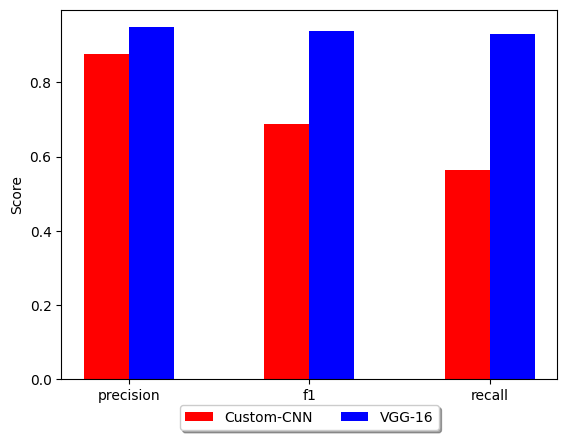

In [42]:
barwidth = 0.25

br1 = np.arange(3)
br2 = [x + barwidth for x in br1]


plt.bar(br1, performance_metrics.values(), width = barwidth, color = 'r', label='Custom-CNN')
plt.bar(br2, performance_metrics_vgg16.values(), width = barwidth,color = 'b', label = 'VGG-16')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks([r + barwidth/2 for r in range(3)], performance_metrics.keys())
plt.show()

##Conclusion

1. In terms of precision both Custom-CNN and VGG-16 performed very well.
2. In terms of f1 & recall metrics there is a huge difference between Custom-CNN and VGG-16 because in custom network our training dataset is relatively small so it was unable to generalize well.